In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import sys
import random 
import numpy as np

sys.path.append('/content/drive/Shareddrives/Drift_Correction')

In [12]:
import correction
import emip_toolkit as EMTK 
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

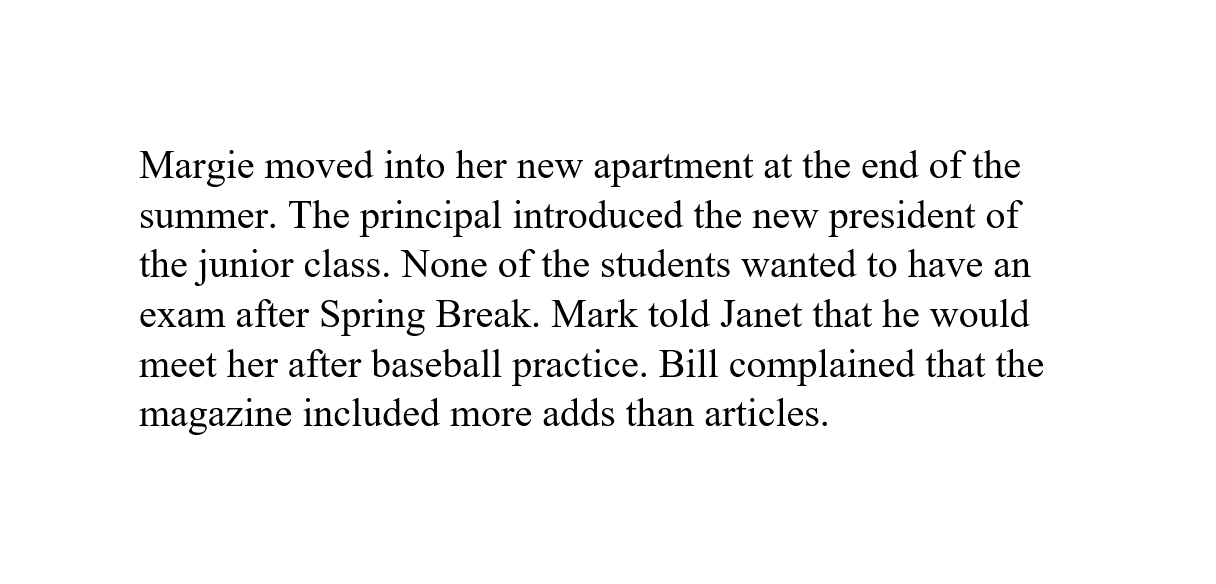

In [13]:
from IPython.display import Image
img = Image(filename= '/content/drive/Shareddrives/Drift_Correction/synthetic_text.png')
img

In [14]:
image_path = "/content/drive/Shareddrives/Drift_Correction/"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
aoi.head()

,kind,name,x,y,width,height,image
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png


In [15]:
file_path = "/content/drive/Shareddrives/Drift_Correction/"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

,kind,name,x,y,width,height,image,token
0,sub-line,line 1 part 1,137.5,147,119,44,synthetic_text.png,Margie
1,sub-line,line 1 part 2,262.5,147,114,44,synthetic_text.png,moved
2,sub-line,line 1 part 3,382.5,147,65,44,synthetic_text.png,into
3,sub-line,line 1 part 4,453.5,147,57,44,synthetic_text.png,her
4,sub-line,line 1 part 5,514.5,147,72,44,synthetic_text.png,new


In [16]:
line_ys = correction.find_lines_Y(aois_with_tokens)

# Offset Error:

In [17]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

synth_fixations = correction.generate_fixations_left_skip_regression(aois_with_tokens)

for index in tqdm(range(100)):
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_offset(error_probability*5, error_probability*5, synth_fixations)

        # attach correction
        np_array = np.array(error_test.copy())
        attach_correction = algo.attach(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, attach_correction)
        attach_results[error_probability].append(percentage)

        # chain correction
        np_array = np.array(error_test.copy())
        chain_correction = algo.chain(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, chain_correction)
        chain_results[error_probability].append(percentage)

        # cluster correction
        np_array = np.array(error_test.copy())
        cluster_correction = algo.cluster(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, cluster_correction)
        cluster_results[error_probability].append(percentage)

        # compare correction
        np_array = np.array(error_test.copy())
        compare_correction = algo.compare(np_array, duration_word_centers)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, compare_correction)
        compare_results[error_probability].append(percentage)

        # merge correction
        np_array = np.array(error_test.copy())
        merge_correction = algo.merge(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, merge_correction)
        merge_results[error_probability].append(percentage)
        
        # regress correction
        np_array = np.array(error_test.copy())
        regress_correction = algo.regress(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, regress_correction)
        regress_results[error_probability].append(percentage)

        # segment correction
        np_array = np.array(error_test.copy())
        segment_correction = algo.segment(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, segment_correction)
        segment_results[error_probability].append(percentage)
        
        # split correction
        np_array = np.array(error_test.copy())
        split_correction = algo.split(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, split_correction)
        split_results[error_probability].append(percentage)
        
        # stretch correction
        np_array = np.array(error_test.copy())
        stretch_correction = algo.stretch(np_array, line_ys)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, stretch_correction)
        stretch_results[error_probability].append(percentage)
        
        # warp correction
        np_array = np.array(error_test.copy(), dtype=int)
        durations = np.delete(np_array, 0, 1)
        durations = np.delete(durations, 0, 1)
        np_array = np.delete(np_array, 2, 1)
        
        warp_correction = algo.warp(np_array, word_centers)
        percentage, match_list = correction.correction_quality(aoi, synth_fixations, warp_correction)
        warp_results[error_probability].append(percentage)


100%|██████████| 100/100 [1:11:35<00:00, 42.96s/it]


In [18]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [19]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_regress_results = mean_error_group(regress_results)
mean_segment_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)
mean_warp_results = mean_error_group(warp_results)

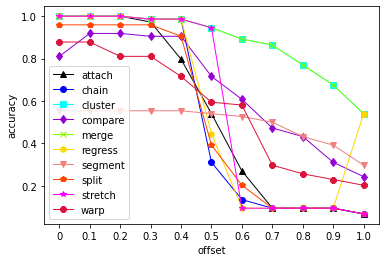

In [20]:
import matplotlib.pyplot as plt
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_cluster_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_compare_results, color='DarkViolet', linewidth=1, marker='d')
plt.plot(mean_merge_results, color='Chartreuse', linewidth=1, marker='x')
plt.plot(mean_regress_results, color='Gold', linewidth=1, marker='h')
plt.plot(mean_segment_results, color='lightcoral', linewidth=1, marker='v')
plt.plot(mean_split_results, color='orangered', linewidth=1, marker='p')
plt.plot(mean_stretch_results, color='magenta', linewidth=1, marker='*')
plt.plot(mean_warp_results, color='crimson', linewidth=1, marker='8')

plt.legend(['attach', 'chain', 'cluster', 'compare', 'merge', 'regress', 'segment', 'split', 'stretch', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('offset')

x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
plt.savefig("/content/drive/Shareddrives/Drift_Correction/offset_correction.png")
plt.show()

In [21]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean segment:", statistics.mean(mean_segment_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))
print("mean warp:", statistics.mean(mean_warp_results))

mean attach: 0.5393120393120393
mean chain: 0.5245700245700246
mean cluster: 0.8783783783783784
mean compare: 0.6584766584766585
mean merge: 0.8783783783783784
mean regress: 0.5761670761670762
mean segment: 0.4963144963144963
mean split: 0.5171990171990172
mean stretch: 0.5786240786240786
mean warp: 0.5687960687960688
